## Overall Statistics and Certificate Issuers

### Import libraries

In [1]:
import os
import pandas as pd 
import numpy as np
from lxml import etree 
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 200
import os
import glob
import time
import re
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import matplotlib.patches as mpatches
import shutil
from IPython.display import clear_output
pd.set_option('display.max_rows', 500)
from manuf import manuf
from user_agents import parse
import dataframe_image as dfi
import tldextract

## 5.1 Statistics on dataset

### Readin datasets

In [2]:
dev = pd.read_parquet("../datasets/ny_serv_withcrt.parquet")

In [3]:
dev.sample(1)

,cert_alg_element,cert_basicConstraints_cA,cert_id,cert_idx,cert_ifCRLSign,cert_ifDataEncipherment,cert_ifDigitalSig,cert_ifKeyCertSign,cert_ifKeyEncipherment,cert_issuer,cert_keyIdentifier,cert_public_key_exponent,cert_resourceIdentifier,cert_san,cert_sct_logid,cert_serialNum_from_ber,cert_serialNum_from_x509af,cert_sig_hash_hash,cert_sig_hash_sig,cert_sig_len,cert_sortedtime,cert_subject,cert_subjectKeyIdentifier,cert_version,serv_curve,cert_notBefore,cert_notAfter,cert_validity_days,cert_mapped_idx,cert_cap_ts,cert_cap_uts,cert_ip_dst,cert_ip_src,cert_tcp_dstport,cert_tcp_srcport,cert_ts_idx_end,cert_ts_idx_start,issuer_CN,issuer_O,issuer_OUnit,issuer_C,subject_CN,subject_O,subject_OUnit,subject_C,cert_sig_alg,if_weak_sig_alg,dev_dst_ip_x,dev_dst_port_x,dev_dst_sni,cert_idx_list,cert_loc,cert_chain_len,chain_issuer,chain_issuer_O,chain_issuer_CN,chain_subject,chain_subject_O,chain_subject_CN,chain_basicConstraintsCA,chain_ifKeyCertSign,chain_keyIdentifier,chain_subjectIdentifier,chain_serial_from_ber,chain_serial_from_x509af,client_ciphersuite_code,client_compression_method,client_extension_type_code,client_hello_id,client_idx,client_sig_hash_alg_code,client_sig_hash_hash_code,client_supported_group_code,server_name_indication,clnt_mapped_idx,clnt_cap_ts,clnt_cap_uts,clnt_ip_dst,clnt_ip_src,clnt_tcp_dstport,clnt_tcp_srcport,clnt_ts_idx_end,clnt_ts_idx_start,client_tls_version,client_ciphersuite,client_extension_type,client_supported_groups,client_sig_hash_alg,client_sig_hash_hash,if_weak_cipher_included,weak_cipher_included,weak_sigalg_included,if_tls_fallback,if_weak_sigalg,dev_dst_ip_y,dev_dst_port_y,server_ciphersuite,server_ciphersuite_code,server_compression_method,server_extension_type_code,server_hello_id,server_idx,server_tls_version,serv_mapped_idx,serv_cap_ts,serv_cap_uts,serv_ip_dst,serv_ip_src,serv_tcp_dstport,serv_tcp_srcport,serv_ts_idx_end,serv_ts_idx_start,server_extension_type,if_weak_cipher,dev_dst_ip,dev_dst_port,serial_num,response
13653,rsaEncryption,NaN,1.0,155.0,NaN,NaN,NaN,NaN,NaN,"rdnSequence: 3 items (id-at-commonName=DigiCert SHA2 Secure Server CA,id-at-organizationName=DigiCert Inc,id-at-countryName=US)",0f80611c823161d52f28e78d4638b42ce1c6d9e2,65537.0,http://crl3.digicert.com/ssca-sha2-g6.crl,"*.urbanairship.com,urbanairship.com,",2979bef09e393921f056739f63a577e5be577d9c600af8f94d5d265c255dc784,NaN,02959bf7bf2c284543d5a4dbabb15c54,SHA256,ECDSA,NaN,"['2020-06-09 00:00:00 (UTC)', '2022-07-14 12:00:00 (UTC)']","rdnSequence: 6 items (id-at-commonName=*.urbanairship.com,id-at-organizationalUnitName=Operations,id-at-organizationName=Urban Airship, Inc.,id-at-localityName=Portland,id-at-stateOrProvinceName=O...",97474bbe7b7e8e772da0e0fb130cf45e760583ae,v3,None,2020-06-09 00:00:00,2022-07-14 12:00:00,765 days 12:00:00,3,"Apr 16, 2022 13:24:45.889406000 EDT",1.650130e+09,67.205.150.252,35.201.74.116,44924,443,473.0,3.0,DigiCert SHA2 Secure Server CA,DigiCert Inc,NaN,US,*.urbanairship.com,Urban Airship,NaN,US,sha256WithRSAEncryption,False,35.201.74.116,443,remote-data.urbanairship.com,"[155.0, 333.0]",0,2,"[rdnSequence: 3 items (id-at-commonName=DigiCert SHA2 Secure Server CA,id-at-organizationName=DigiCert Inc,id-at-countryName=US), rdnSequence: 4 items (id-at-commonName=DigiCert Global Root CA,id-...","[DigiCert Inc, DigiCert Inc]","[DigiCert SHA2 Secure Server CA, DigiCert Global Root CA]","[rdnSequence: 6 items (id-at-commonName=*.urbanairship.com,id-at-organizationalUnitName=Operations,id-at-organizationName=Urban Airship, Inc.,id-at-localityName=Portland,id-at-stateOrProvinceName=...","[Urban Airship, DigiCert Inc]","[*.urbanairship.com, DigiCert SHA2 Secure Server CA]","[nan, 1.0]","[None, None]","[0f80611c823161d52f28e78d4638b42ce1c6d9e2, 03de503556d14cbb66f0a3e21b1bc397b23dd155]","[97474bbe7b7e8e772da0e0fb130cf45e760583ae, 0f80611c823161d52f28e78d4638b42ce1c6d9e2]","[None, None]","[02959bf7bf2c284543d5a4dbabb15c54, 01fda3eb6eca75c888438b724bcfbc91]","['c02c', 'c030', '009f', 'cca9', 'cca8', 'ccaa

In [4]:
names = pd.read_parquet("../datasets/sni_used_to_generate_pcaps.parquet")

### Merge to obtain device information

In [5]:
dev_withid = pd.merge(dev, names, how='left', left_on='server_name_indication', right_on='sni')

In [6]:
dev_withid.shape

(371079, 123)

In [7]:
dev_withid.loc[dev_withid['device_id'].isna()].shape

(0, 123)

### Statistics

In [8]:
dev_withid.groupby(['serial_num', 'issuer_CN'])['device_id'].agg('count').reset_index(name='count').shape

(842, 3)

In [9]:
dev_withid['sni'].value_counts().shape

(1151,)

In [13]:
dev_withid.loc[dev_withid['device_vendor'] != "unknown"]['device_vendor'].value_counts().shape

(65,)

In [21]:
## the same issuer with different name included
dev_withid['issuer_O'].value_counts()

DigiCert Inc                        114611
Google Trust Services LLC            99985
Amazon                               78816
Netflix                              13422
Roku                                 12537
Sectigo Limited                       8910
GoDaddy.com                           6022
GlobalSign nv-sa                      5286
Apple Inc.                            3701
COMODO CA Limited                     3255
Samsung Electronics                   3210
Cloudflare                            3122
Nest Labs                             3040
Sony Computer Entertainment Inc.      2397
Microsoft Corporation                 2395
Nintendo of America Inc.              1685
Let's Encrypt                         1525
Nintendo of America                   1100
Comodo Japan                           873
Network Solutions L.L.C.               860
Entrust                                816
Philips Hue                            640
Netflix Inc                            480
Canary Conn

In [22]:
dev_stat = dev_withid.groupby(['serial_num', 'issuer_CN'])['sni']\
                     .agg(lambda x: x.nunique()).reset_index(name='num_sni')

In [23]:
dev_stat.sample(2)

,serial_num,issuer_CN,num_sni
606,0e89e157eaac5464de298184c3b3ec31,DigiCert TLS RSA SHA256 2020 CA1,1
587,0e0ce8317efe39327a4a661a639afa69,DigiCert Global CA G2,1


In [24]:
dev_stat[dev_stat['num_sni'] == dev_stat['num_sni'].max()]

,serial_num,issuer_CN,num_sni
23,00ba1bd1a082861a8e1200000000068b53,GTS CA 1C3,32


In [25]:
dev_stat['num_sni'].mean()

1.7185273159144894

In [26]:
dev_stat['num_sni'].var()

5.531856092594214

In [27]:
dev_ip = dev_withid[['serial_num', 'issuer_CN', 'sni', 'cert_ip_src']]

In [28]:
dev_ipstat = dev_withid.groupby(['serial_num', 'issuer_CN'])['cert_ip_src']\
                       .agg(lambda x: x.nunique()).reset_index(name='num_ip')

In [29]:
dev_ipstat.sample(2)

,serial_num,issuer_CN,num_ip
458,0abc3881e7ccb4abd8a9147f9d9883c2,DigiCert TLS RSA SHA256 2020 CA1,4
425,0a0bc641b77a8ffdc3c97f53849a43ba,DigiCert TLS RSA SHA256 2020 CA1,1


In [30]:
dev_servip_stat = pd.merge(dev_stat, dev_ipstat, \
                           left_on=['serial_num', 'issuer_CN'], \
                           right_on=['serial_num', 'issuer_CN'], \
                           how='inner')

In [31]:
dev_servip_stat.sample(2)

,serial_num,issuer_CN,num_sni,num_ip
461,0ac8f3034c07ae64f5f5efb934bf1da4,DigiCert TLS RSA SHA256 2020 CA1,1,1
455,0aafecabdb6d008d9f9feba0d16bd750,GeoTrust RSA CA 2018,3,4


In [32]:
dev_servip_stat[dev_servip_stat['num_ip'] == dev_servip_stat['num_ip'].max()]

,serial_num,issuer_CN,num_sni,num_ip
448,0a7d777742b470e4766b807438f0c184,Amazon,21,93


In [33]:
dev_servip_stat['num_ip'].mean()

5.42874109263658

In [34]:
dev_servip_stat['num_ip'].var()

90.66138462016431

In [35]:
dev_servip_stat.loc[dev_servip_stat['num_ip'] > 1].shape

(547, 4)

In [36]:
dev_servip_stat.loc[dev_servip_stat['num_ip'] > 1]['num_ip'].mean()

7.817184643510055

In [37]:
temp_max = dev_servip_stat.loc[dev_servip_stat['num_ip'] > 1]

In [38]:
temp_max[temp_max['num_ip'] == temp_max['num_ip'].max()]

,serial_num,issuer_CN,num_sni,num_ip
448,0a7d777742b470e4766b807438f0c184,Amazon,21,93


## 5.2 Issuer

### Drop columns that will not be used in the analysis

In [39]:
_col2drop = ['cert_keyIdentifier', 'cert_sortedtime', 'cert_subjectKeyIdentifier', 'cert_mapped_idx', \
             'cert_cap_ts', 'cert_cap_uts', 'dev_dst_ip_x', 'dev_dst_port_x', 'dev_dst_sni', 'cert_idx_list', \
             'client_ciphersuite_code', 'client_compression_method', 'client_extension_type_code', 'client_hello_id', \
             'client_idx', 'client_sig_hash_alg_code', 'client_sig_hash_hash_code', 'client_supported_group_code', \
             'clnt_mapped_idx', 'clnt_cap_ts', 'clnt_cap_uts', 'clnt_ip_dst', 'clnt_ip_src', 'clnt_tcp_dstport', \
             'clnt_tcp_srcport', 'clnt_ts_idx_end', 'clnt_ts_idx_start', 'client_tls_version', 'client_ciphersuite', \
             'client_extension_type', 'client_supported_groups', 'client_sig_hash_alg', 'client_sig_hash_hash', \
             'if_weak_cipher_included', 'weak_cipher_included', 'weak_sigalg_included', 'dev_dst_ip_y', 'dev_dst_port_y', \
             'cert_ts_idx_end', 'cert_ts_idx_start', 'server_hello_id', 'server_idx', 'serv_mapped_idx', 'serv_cap_ts', \
             'serv_cap_uts', 'serv_ip_dst', 'serv_ip_src', 'serv_tcp_dstport', 'serv_tcp_srcport', 'serv_ts_idx_end', \
             'serv_ts_idx_start', 'dev_dst_ip', 'dev_dst_port']

In [40]:
dev_dropcol = dev_withid.drop([*_col2drop], 1)

In [41]:
dev_dropcol.columns

Index(['cert_alg_element', 'cert_basicConstraints_cA', 'cert_id', 'cert_idx',
       'cert_ifCRLSign', 'cert_ifDataEncipherment', 'cert_ifDigitalSig',
       'cert_ifKeyCertSign', 'cert_ifKeyEncipherment', 'cert_issuer',
       'cert_public_key_exponent', 'cert_resourceIdentifier', 'cert_san',
       'cert_sct_logid', 'cert_serialNum_from_ber',
       'cert_serialNum_from_x509af', 'cert_sig_hash_hash', 'cert_sig_hash_sig',
       'cert_sig_len', 'cert_subject', 'cert_version', 'serv_curve',
       'cert_notBefore', 'cert_notAfter', 'cert_validity_days', 'cert_ip_dst',
       'cert_ip_src', 'cert_tcp_dstport', 'cert_tcp_srcport', 'issuer_CN',
       'issuer_O', 'issuer_OUnit', 'issuer_C', 'subject_CN', 'subject_O',
       'subject_OUnit', 'subject_C', 'cert_sig_alg', 'if_weak_sig_alg',
       'cert_loc', 'cert_chain_len', 'chain_issuer', 'chain_issuer_O',
       'chain_issuer_CN', 'chain_subject', 'chain_subject_O',
       'chain_subject_CN', 'chain_basicConstraintsCA', 'chain_ifKeyCert

### Issuer Overview

In [42]:
dev_dropcol.shape

(371079, 70)

In [43]:
dev_dropcol['sni'] = dev_dropcol['sni'].fillna("missing")

In [44]:
dev_dropcol['issuer_O'] = dev_dropcol['issuer_O'].fillna("missing")

In [45]:
dev_dropcol['issuer_CN'] = dev_dropcol['issuer_CN'].fillna("missing")

### Get domain

In [46]:
dev_dropcol['domain'] = dev_dropcol['sni'].apply(lambda x: "{}.{}".format(tldextract.extract(x).domain, tldextract.extract(x).suffix))

### Parse issuer organizations

In [47]:
def parse_issuer(text):
    if text.startswith('mediasoup'):
        return "mediasoup"
    return text.replace('\\', '').replace('\"', '')\
               .split(" Inc")[0].split(" INC")[0].split(" L.L.C.")[0].split(" LLC")[0].split(" llc")[0].split(" Hue")[0]\
               .split(" Co.")[0].split(" CO.")[0].split(" Ltd")[0].split(" Limited")[0].split(" GmbH")[0].split(" inc")[0].split(" CA")[0]

### Rename

In [48]:
dev_dropcol.issuer_O[dev_dropcol['issuer_CN'].str.contains('Tesla')] = 'Tesla Motor Services'
dev_dropcol.issuer_O[dev_dropcol['issuer_CN'].str.contains('TP-LINK')] = 'TP-Link'
dev_dropcol.issuer_O[dev_dropcol['issuer_CN'].str.contains('AIRTIES')] = 'AirTies'
dev_dropcol.issuer_O[dev_dropcol['issuer_O'].str.contains('Samsung')] = 'Samsung Electronics'
dev_dropcol.issuer_O[dev_dropcol['issuer_O'].str.contains('Comodo')] = 'COMODO'
dev_dropcol.issuer_O[dev_dropcol['issuer_O'] == 'nan'] = 'Tuya'

<ipython-input-48-fc8a4e3c8e6b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_dropcol.issuer_O[dev_dropcol['issuer_CN'].str.contains('Tesla')] = 'Tesla Motor Services'
<ipython-input-48-fc8a4e3c8e6b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_dropcol.issuer_O[dev_dropcol['issuer_CN'].str.contains('TP-LINK')] = 'TP-Link'
<ipython-input-48-fc8a4e3c8e6b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_dropcol.issuer_

In [49]:
pd.set_option('display.max_colwidth', None)

### Drop records with unknown devices

In [50]:
dev_dropcol = dev_dropcol.loc[dev_dropcol['device_vendor'] != "Unknown"]

In [51]:
dev_dropcol['issuer_O'] = dev_dropcol['issuer_O'].apply(lambda x: parse_issuer(x))

In [52]:
dev_dropcol['issuer_O'].value_counts()

DigiCert                          114611
Google Trust Services              99985
Amazon                             78816
Netflix                            13902
Roku                               12537
Sectigo                             8910
GoDaddy.com                         6022
GlobalSign nv-sa                    5286
COMODO                              4128
Apple                               3701
Samsung Electronics                 3270
Cloudflare                          3122
Nest Labs                           3040
Nintendo of America                 2785
Sony Computer Entertainment         2397
Microsoft Corporation               2395
Let's Encrypt                       1525
Network Solutions                    860
Entrust                              816
Philips                              640
Tesla Motor Services                 380
Canary Connect                       340
LG Electronics                       240
TAIWAN-CA                            220
Gandi           

### Organize issuer organization info

In [53]:
vendor_issuerlis = ['Roku', 'Samsung Electronics', 'Nest Labs', 'Nintendo of America', 'Sony Computer Entertainment', \
                    'Philips', 'Tesla Motor Services', 'Canary Connect', 'LG Electronics', 'Sense Labs', \
                    'Universal Electronics', 'ecobee', 'Obihai Technology', 'ATT Mobility and Entertainment', \
                    'EchoStar', 'Tuya']

In [54]:
dev_dropcol.loc[dev_dropcol['issuer_O'].isin(vendor_issuerlis)].drop_duplicates(['issuer_O', 'issuer_CN', 'serial_num']).shape

(60, 71)

In [55]:
dev_dropcol.loc[dev_dropcol['issuer_O'].isin(vendor_issuerlis)]['device_id'].value_counts().shape

(391,)

### Plot

In [56]:
dev_dropdup = dev_dropcol.drop_duplicates(subset=['issuer_O', 'issuer_CN', 'serial_num', \
                                                  'sni', 'device_vendor'])

In [57]:
dev_dropdup.shape

(4949, 71)

In [58]:
cat_cnt = dev_dropdup.groupby(['device_vendor'])['sni'].agg('count').reset_index(name='total')

In [59]:
cat_cnt.shape

(66, 2)

### Public trust issuer organization list

In [61]:
public_lis = ['DigiCert', 'Amazon', 'Google Trust Services', 'Microsoft Corporation', 'Sectigo', 'GlobalSign nv-sa', \
              'GoDaddy.com', "Let's Encrypt", "Cloudflare", "Network Solutions", "Entrust", "Apple", "COMODO CA", \
              "COMODO Japan", "ZeroSSL", "Gandi", "TAIWAN-CA", "cPanel"]

In [64]:
issuer = dev_dropdup.groupby('issuer_O')['cert_id'].agg('count').reset_index(name='count').sort_values('count', ascending=False)

In [65]:
issuer.head(2)

,issuer_O,count
6,DigiCert,2338
12,Google Trust Services,791


In [66]:
sum(issuer['count'])

4949

### Calculate DigiCert percentage

In [67]:
2338/4949

0.4724186704384724

In [68]:
issuer.shape

(35, 2)

In [69]:
issuer

,issuer_O,count
6,DigiCert,2338
12,Google Trust Services,791
1,Amazon,555
17,Netflix,262
24,Sectigo,182
15,Microsoft Corporation,158
2,Apple,135
5,Cloudflare,81
22,Roku,78
11,GoDaddy.com,76


In [70]:
issuer_lis = issuer['issuer_O'].tolist()

In [71]:
dev_dropdup['signed_by_public'] = dev_dropdup['issuer_O'].apply(lambda x: 1 if x in (public_lis) else 0)

<ipython-input-71-2ab8b34aea2d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_dropdup['signed_by_public'] = dev_dropdup['issuer_O'].apply(lambda x: 1 if x in (public_lis) else 0)


In [72]:
dev_issuer = dev_dropdup.groupby(['device_vendor', 'issuer_O'])['cert_id']\
                        .agg('count').reset_index(name='count').sort_values('count', ascending=False)

In [73]:
dev_public = dev_dropdup.groupby(['device_vendor'])['signed_by_public'].agg('sum').reset_index(name='signed_by_public')\
                        .sort_values('signed_by_public', ascending=False)

In [74]:
dev_issuer.shape

(323, 3)

In [75]:
dev_merge = pd.merge(cat_cnt, dev_issuer, how='inner', left_on='device_vendor', right_on='device_vendor')

In [76]:
dev_merge = pd.merge(dev_merge, dev_public, how='inner', left_on='device_vendor', right_on='device_vendor')

In [77]:
dev_merge['perc'] = dev_merge['count'] / dev_merge['total']

In [78]:
dev_merge['pub_perc'] = dev_merge['signed_by_public'] / dev_merge['total']

### Rename

In [79]:
dev_merge['device_vendor'] = dev_merge['device_vendor'].apply(lambda x: x.capitalize())

In [81]:
dev_merge.device_vendor[dev_merge['device_vendor'].str.contains('Lg')] = 'LG'
dev_merge.device_vendor[dev_merge['device_vendor'].str.contains('Directv')] = 'DirecTV'
dev_merge.device_vendor[dev_merge['device_vendor'].str.contains('Dish network')] = 'Dish Network'
dev_merge.device_vendor[dev_merge['device_vendor'].str.contains('Tcl')] = 'TCL'
dev_merge.device_vendor[dev_merge['device_vendor'].str.contains('Tplink')] = 'TP-Link'
dev_merge.device_vendor[dev_merge['device_vendor'].str.contains('Western digital')] = 'Western Digital'
dev_merge.device_vendor[dev_merge['device_vendor'].str.contains('Hp')] = 'HP'
dev_merge.device_vendor[dev_merge['device_vendor'].str.contains('Ihome')] = 'iHome'
dev_merge.device_vendor[dev_merge['device_vendor'].str.contains('Ikea')] = 'IKEA'
dev_merge.device_vendor[dev_merge['device_vendor'].str.contains('Irobot')] = 'iRobot'
dev_merge.device_vendor[dev_merge['device_vendor'].str.contains('Netgear')] = 'NETGEAR'
dev_merge.device_vendor[dev_merge['device_vendor'].str.contains('Qnap')] = 'QNAP'
dev_merge.device_vendor[dev_merge['device_vendor'].str.contains('Sleep number')] = 'Sleep Number'
dev_merge.device_vendor[dev_merge['device_vendor'].str.contains('Echobee')] = 'echobee'
dev_merge.device_vendor[dev_merge['device_vendor'].str.contains('Idevices')] = 'iDevices'
dev_merge.device_vendor[dev_merge['device_vendor'].str.contains('Vmware')] = 'VMware'
dev_merge.device_vendor[dev_merge['device_vendor'].str.contains('Hdhomerun')] = 'HDHomeRun'
dev_merge.device_vendor[dev_merge['device_vendor'].str.contains('Ecobee')] = 'ecobee'
dev_merge.device_vendor[dev_merge['device_vendor'].str.contains('Texas instruments')] = 'Texas Instruments'

<ipython-input-81-bb924bdf8ea9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_merge.device_vendor[dev_merge['device_vendor'].str.contains('Lg')] = 'LG'
<ipython-input-81-bb924bdf8ea9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_merge.device_vendor[dev_merge['device_vendor'].str.contains('Directv')] = 'DirecTV'
<ipython-input-81-bb924bdf8ea9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_merge.device_vendor[dev_me

In [82]:
dev_merge = dev_merge.loc[dev_merge['device_vendor'] != "Unknown"]

In [83]:
dev_issuer_reshape = dev_merge.pivot(index='issuer_O', columns='device_vendor', values='perc')

In [84]:
dev_issuer_reshape = dev_issuer_reshape.fillna(0)

In [85]:
dev_issuer_reshape = dev_issuer_reshape.reindex(issuer_lis)

In [86]:
dev_issuer_reshape = dev_issuer_reshape.dropna(axis=0)

In [87]:
dev_public_lis = dev_merge.sort_values(by='pub_perc', ascending=False)['device_vendor'].tolist()

### Sort x-axis

In [88]:
sorted_lis = []
for vendor in dev_public_lis:
    if vendor not in sorted_lis:
        sorted_lis.append(vendor)

In [89]:
sorted_lis

['Yamaha',
 'Fing',
 'iDevices',
 'QNAP',
 'HDHomeRun',
 'Epson',
 'Denon',
 'Logitech',
 'Silicondust',
 'Skybell',
 'Sleep Number',
 'Sonos',
 'IKEA',
 'Pioneer',
 'Lutron',
 'Marantz',
 'Nanoleaf',
 'NETGEAR',
 'iRobot',
 'Onkyo',
 'Ubiquity',
 'Belkin',
 'Arlo',
 'TP-Link',
 'Canon',
 'Bose',
 'Vera',
 'Wyze',
 'Withings',
 'Western Digital',
 'VMware',
 'Google',
 'HP',
 'Cisco',
 'Synology',
 'Amazon',
 'Vizio',
 'LG',
 'Samsung',
 'Nvidia',
 'Tivo',
 'Xiaomi',
 'Roku',
 'Sony',
 'DirecTV',
 'Wink',
 'Tesla',
 'Texas Instruments',
 'Insignia',
 'TCL',
 'Humax',
 'Philips',
 'ecobee',
 'Brother',
 'Sharp',
 'Sense',
 'Amcrest',
 'Nintendo',
 'Netatmo',
 'Panasonic',
 'Sky',
 'Dish Network',
 'Canary',
 'Tuya',
 'Obihai']

In [90]:
dev_issuer_reshape.sample(2)

device_vendor,Amazon,Amcrest,Arlo,Belkin,Bose,Brother,Canary,Canon,Cisco,Denon,DirecTV,Dish Network,Epson,Fing,Google,HDHomeRun,HP,Humax,IKEA,Insignia,LG,Logitech,Lutron,Marantz,NETGEAR,Nanoleaf,Netatmo,Nintendo,Nvidia,Obihai,Onkyo,Panasonic,Philips,Pioneer,QNAP,Roku,Samsung,Sense,Sharp,Silicondust,Sky,Skybell,Sleep Number,Sonos,Sony,Synology,TCL,TP-Link,Tesla,Texas Instruments,Tivo,Tuya,Ubiquity,VMware,Vera,Vizio,Western Digital,Wink,Withings,Wyze,Xiaomi,Yamaha,ecobee,iDevices,iRobot
issuer_O,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Nintendo of America,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Tuya,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [91]:
dev_issuer_reshape = dev_issuer_reshape.reindex(columns=sorted_lis)

In [92]:
dev_issuer_reshape.sample(2)

device_vendor,Yamaha,Fing,iDevices,QNAP,HDHomeRun,Epson,Denon,Logitech,Silicondust,Skybell,Sleep Number,Sonos,IKEA,Pioneer,Lutron,Marantz,Nanoleaf,NETGEAR,iRobot,Onkyo,Ubiquity,Belkin,Arlo,TP-Link,Canon,Bose,Vera,Wyze,Withings,Western Digital,VMware,Google,HP,Cisco,Synology,Amazon,Vizio,LG,Samsung,Nvidia,Tivo,Xiaomi,Roku,Sony,DirecTV,Wink,Tesla,Texas Instruments,Insignia,TCL,Humax,Philips,ecobee,Brother,Sharp,Sense,Amcrest,Nintendo,Netatmo,Panasonic,Sky,Dish Network,Canary,Tuya,Obihai
issuer_O,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
GoDaddy.com,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.058824,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.011682,0.0,0.012931,0.088235,0.013605,0.054054,0.016349,0.011215,0.013761,0.017341,0.006061,0.014403,0.025237,0.0,0.024096,0.000000,0.2,0.0,0.014388,0.0,0.0,0.0,0.0,0.0,0.0,0.09375,0.0,0.125,0.0,0.0,0.0,0.0,0.0,0.0
Tesla Motor Services,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.013624,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.192308,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0


In [93]:
dev_issuer_reshape_try = dev_issuer_reshape.copy()

In [94]:
mask = np.zeros_like(dev_issuer_reshape_try)

In [95]:
dev_issuer_reshape_mask = (dev_issuer_reshape_try == 0).values

In [96]:
dev_issuer_reshape_mask

array([[False, False, False, ...,  True,  True,  True],
       [ True,  True, False, ...,  True,  True,  True],
       [ True,  True, False, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True, False,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

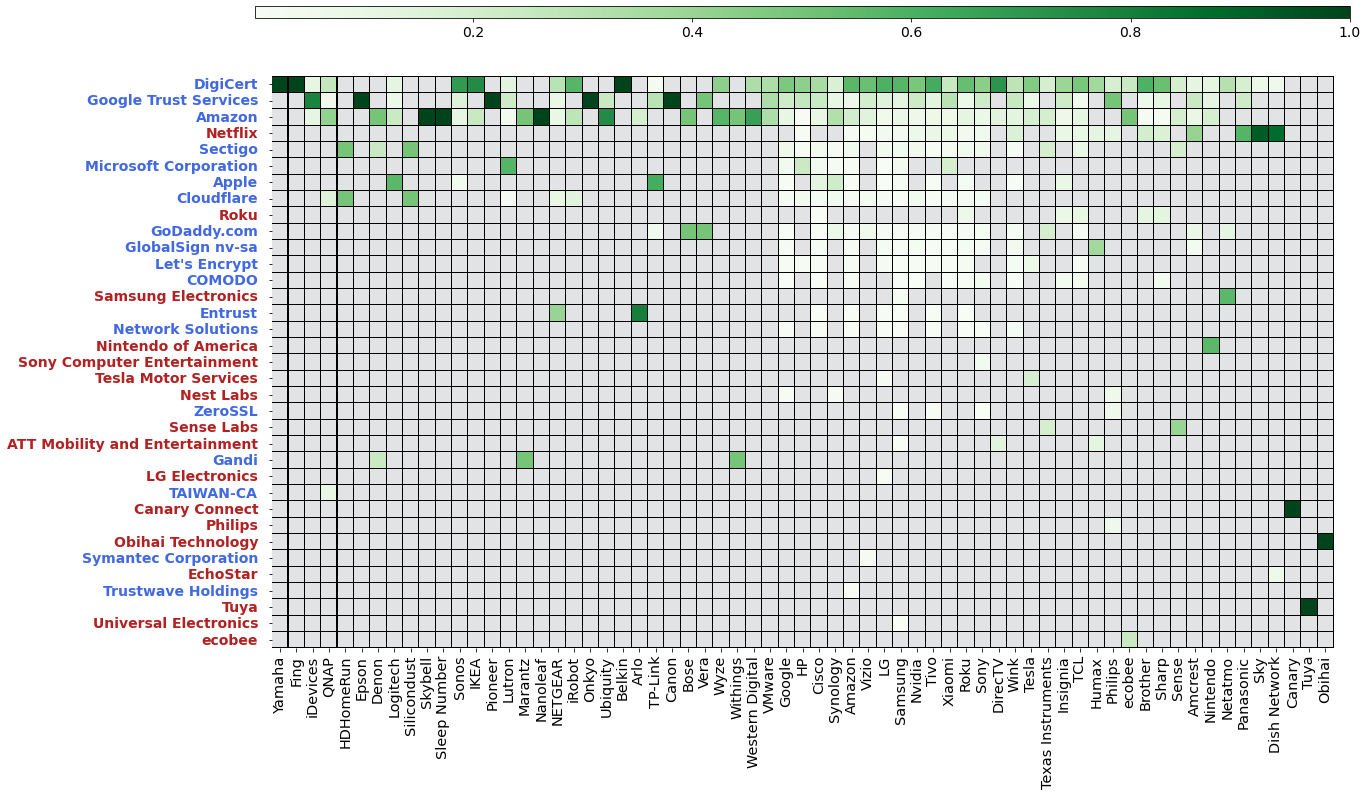

In [97]:
#fig = plt.figure(figsize=(18, 9))
#cbar_kws={"shrink": .5, "orientation": "horizontal"},

fig, (cax, ax) = plt.subplots(nrows=2, figsize=(19, 11), gridspec_kw={"height_ratios":[0.02, 1]})
ax = sns.heatmap(dev_issuer_reshape_try, cmap="Greens", ax=ax, square=True, cbar=False, linecolor='black', mask = dev_issuer_reshape_mask, linewidths=.1)

cbar = fig.colorbar(ax.get_children()[0], cax=cax, orientation="horizontal")
cbar.ax.tick_params(labelsize=14) 


ax.set_facecolor("#E1E3E5")
#ax.set_facecolor(((0.0, 0.0, 0.0, 0.3)))

#fig.colorbar(ax.get_children()[0], cax=cax, fraction=0.046, pad=0.04, orientation="horizontal")

plt.ylabel("")
plt.xlabel("")

pub_lis = [0,1,2,4,5,6,7,9,10,11,12,14,15,20,23,25,29,31]
for idx in pub_lis:
    ax.get_yticklabels()[idx].set_color("royalblue")
    ax.get_yticklabels()[idx].set_fontweight('bold')
priv_lis = [3,8,13,16,17,18,19,21,22,24,26,27,28,30,32,33,34]
for idx in priv_lis:
    ax.get_yticklabels()[idx].set_color("firebrick")
    ax.get_yticklabels()[idx].set_fontweight('bold')
    
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14.5, ha='center', va='top')
ax.tick_params(axis="y",direction="out", pad=10)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14, va='center')

#fig.tight_layout()
plt.subplots_adjust(left=0.19, right=0.99, bottom=0.18, top=0.99)
plt.show()